# Geo-Temporal Insights from Twitter Data

Data sourced from: 
Helwig, N., Gao, Y., Wang, S., & Ma, P. (2015). Twitter Geospatial Data [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5RS5J.


In [29]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widget 

## Importing Packages & Reading Data  
Overview of columns and data types.


In [30]:
twitter = pd.read_csv('twitter.csv')
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262517 entries, 0 to 14262516
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   timestamp  int64  
 3   timezone   int64  
dtypes: float64(2), int64(2)
memory usage: 435.3 MB


# An Overview: 5 Columns – Longitude, Latitude, Timestamp, and Timezone.

In [31]:
print(twitter.head(5),"\n\n",twitter.tail(5))

   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1 

            longitude   latitude       timestamp  timezone
14262512  -90.703468  42.495940  20130118235955         2
14262513  -80.084576  37.292336  20130118235955         1
14262514  -81.509412  41.574817  20130118235955         1
14262515  -98.181743  26.202471  20130118235955         2
14262516 -122.308808  47.563866  20130118235955         4


# Some Elementary Transformations for Exploration.

In [32]:
twitter.sort_values(by=["timestamp"])
twitter["timestamp"] = pd.to_datetime(twitter["timestamp"],format='%Y%m%d%H%M%S')
twitter["date"] = twitter["timestamp"].dt.date
twitter["time"] = twitter["timestamp"].dt.time

day_date = [str(i.year)+"-"+str(i.month)+"-"+str(i.day) for i in pd.Series(twitter["date"].unique()).tolist()]

In [33]:
from datetime import date

slider = widget.SelectionSlider(options = day_date, description="Select Date:")

def loc_plot(day_date):
    year, month, day = map(int, day_date.split("-"))
    twitter2 = twitter[twitter["date"]==date(year,month,day)]
    twitter2.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

widget.interactive(loc_plot,day_date = slider)

interactive(children=(SelectionSlider(description='Select Date:', options=('2013-1-12', '2013-1-13', '2013-1-1…

# Graphic Is Too Dense for Clear Visualization  
To improve readability, let's simplify the representation using a grid-based approach and replot.

In [34]:
twitter3 = twitter

twitter3["long"]=twitter3["longitude"].apply(lambda x: int(str(x).partition(".")[0]))
twitter3["lat"]=twitter3["latitude"].apply(lambda x: int(str(x).partition(".")[0]))

twitter3_pivot = twitter3.groupby(by=["date", "long", "lat"])["timestamp"].count()
twitter3_pivot.to_frame()
indices = twitter3_pivot.index.to_list()
indices_date_time = [i[0] for i in indices]
indices_long = [i[1] for i in indices]
indices_lat = [i[2] for i in indices]

values=twitter3_pivot.values.tolist()

twitter_aggregate = pd.DataFrame(data = zip(indices_date_time,indices_long,indices_lat,values), 
                                 index=[i for i in range(0,len(values))], 
                                 columns=["daydate","long","lat","Tweet Count"])

In [35]:
def loc_plot2(day_date):
    year, month, day = map(int, day_date.split("-"))
    twitter_aggregate2=twitter_aggregate[twitter_aggregate["daydate"]==date(year,month,day)]
    twitter_aggregate2.plot(figsize=(8,4), kind="scatter",x="long",y="lat",c="Tweet Count",
                            alpha=0.2,colorbar=True,colormap="jet",
                            s=twitter_aggregate2["Tweet Count"]*0.01,
                            xlabel="Longitude", ylabel="Latitude")

widget.interactive(loc_plot2,day_date = slider)

interactive(children=(SelectionSlider(description='Select Date:', options=('2013-1-12', '2013-1-13', '2013-1-1…

# A Few Basic Observations: 
1. Eastern U.S. has a higher volume of tweets compared to other regions.
2. Metropolitan areas have a higher volume of tweets.

let's further explore the first observation.

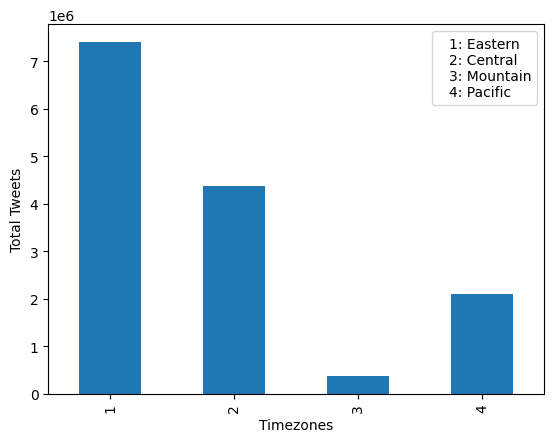

In [36]:
import matplotlib.pyplot as plt

twitter_time_zoned = twitter.pivot_table(index=["timezone"],aggfunc={"timestamp":"count"})

twitter_time_zoned.plot(kind="bar", legend=True, 
                        xlabel="Timezones", ylabel="Total Tweets").legend(["1: Eastern\n2: Central\n3: Mountain\n4: Pacific"], 
                        loc="upper right",markerscale=0, handlelength=0)

# Eastern U.S. Tweets More  
This trend can likely be explained by **population density**, as the Eastern U.S. is significantly more populated than the West.

# Next Steps: Exploring Tweet Trends  
Before proceeding, we should investigate:  
1. Whether there is a **significant difference** in the mean tweet count across days.  
2. Whether this trend can be **modeled using a known statistical distribution**.

In [37]:
daydate_list = twitter_aggregate["daydate"].unique().tolist()

count_by_date={}

for i in daydate_list:
    data_frame=twitter_aggregate[twitter_aggregate['daydate']==i]
    day_date_str = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    count_by_date[day_date_str]=data_frame
    

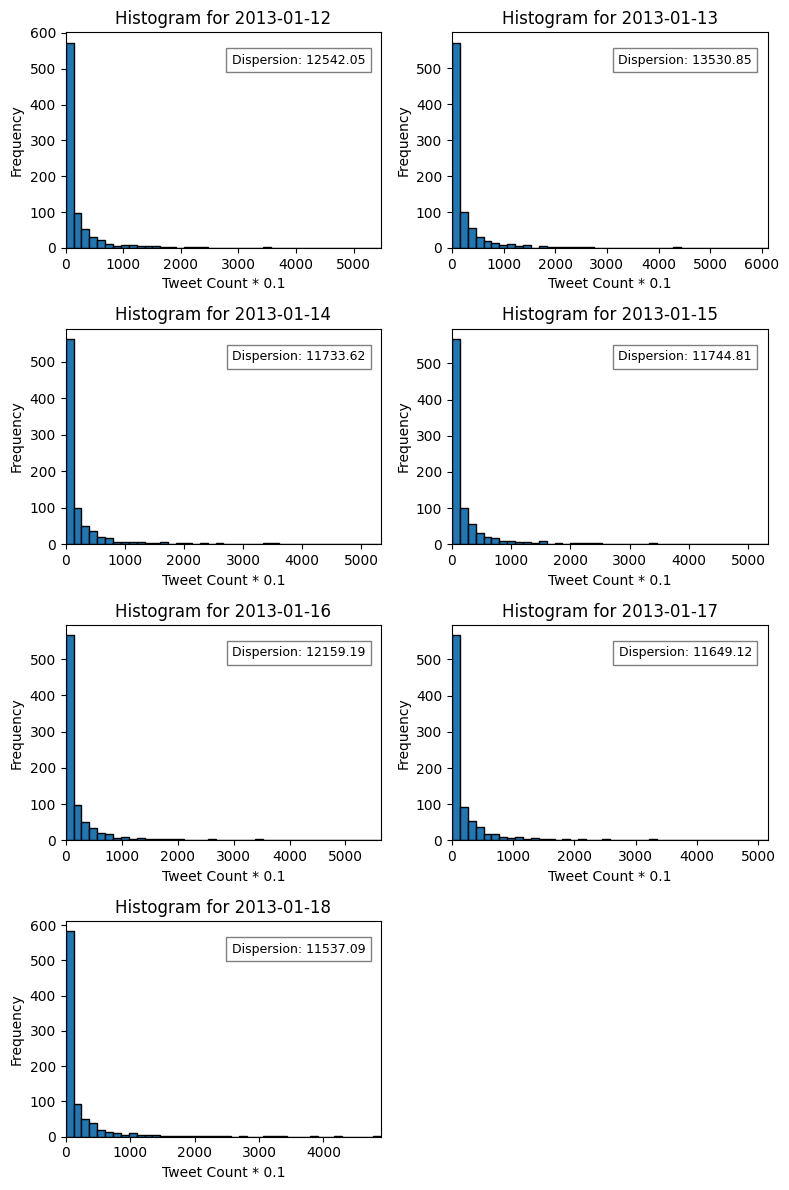

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 12))
axes = axes.flatten()

tweet_count_groups = []

for idx, i in enumerate(count_by_date):
    if idx >= 7:
        break
    var = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    var2 = count_by_date[var]["Tweet Count"]
    tweet_count_groups.append(var2)
    dispersion = round(np.var(var2) / np.mean(var2), 2)

    axes[idx].hist(var2 * 0.1, bins=40, edgecolor='black')
    axes[idx].set_title(f"Histogram for {var}")
    axes[idx].set_xlabel("Tweet Count * 0.1")
    axes[idx].set_ylabel("Frequency")
    axes[idx].set_xlim(0, max(var2 * 0.1))

    axes[idx].text(
        0.95, 0.9, f"Dispersion: {dispersion}",
        transform=axes[idx].transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5)
    )

axes[-1].axis("off")

plt.tight_layout()
plt.show()

# Initial Observations  
From the rough visual, we expect **no significant difference in means**, though periodic spikes may be worth examining further.  
The **high overdispersion in Poisson distributions** is likely driven by trending cycles.

In [39]:
from sklearn.utils import resample

arr_sizes = []

for i in tweet_count_groups:
    arr_sizes.append(len(i))

min_sample = np.max(arr_sizes)

tweet_count_groups_resampled=[]

for i in count_by_date:
    var = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    var2 = count_by_date[var]["Tweet Count"]
    var3 = resample(var2, n_samples=min_sample, random_state=42)
    tweet_count_groups_resampled.append(var3)

In [40]:
from scipy.stats import kruskal

statistic, p_value = kruskal(*tweet_count_groups_resampled)

print(f"Kruskal-Wallis statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

Kruskal-Wallis statistic: 7.730
P-value: 0.259


# Visual Inspection Suggests Similarity in Central Tendency
The Kruskal test confirms this, though the observed **overdispersion appears unreasonable for a Poisson distribution**.

# Random Forest Model – Untuned
Can we get a reasonable model?

In [41]:
twitter_aggregate['daydate'] =  twitter_aggregate['daydate'].apply(lambda x: "".join(str(x).split("-"))).astype(int)

In [42]:
from sklearn.model_selection import train_test_split

features =  twitter_aggregate.drop(columns=['Tweet Count'])
target = twitter_aggregate['Tweet Count']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, 
                                                    shuffle=False, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500,max_depth=15,random_state=42)

rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)

# How Does Our Untuned Model Look?

In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

mean_tweets = twitter_aggregate["Tweet Count"].mean()
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print(f"Mean Tweets: {mean_tweets}")
print(f"RMSE : {rmse}")

percent_diff = (rmse/mean_tweets)*100
print(f"Percent Difference: {percent_diff:.2f}%")

Mean Tweets: 2391.434775318578
RMSE : 472.090786583123
Percent Difference: 19.74%


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rfr = RandomForestRegressor(random_state=42)


param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: -218.90298490238106


In [46]:
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# How Does the Tuned Model Perform?

In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

mean_tweets = twitter_aggregate["Tweet Count"].mean()
rmse_tuned = np.sqrt(mean_squared_error(y_test,y_pred_tuned))

print(f"mean tweets: {mean_tweets}")
print(f"rmse tuned model : {rmse_tuned}")

percent_diff_tuned = (rmse_tuned/mean_tweets)*100
print(f"Percent Difference - tuned model: {percent_diff_tuned:.2f}%")

mean tweets: 2391.434775318578
rmse tuned model : 469.998261116163
Percent Difference - tuned model: 19.65%


# MAE or RMSE: Can We Do Better?  

Our dataset has some limitations due to a handful of outliers, which will inevitably impact RMSE. However, MAE is generally a more suitable metric for this case. If we aim to explore and model these outliers effectively, more granular data—such as portions of the text or contextual insights related to the days they occur (e.g., trends, sports events)—would be necessary.  

Given these considerations, **MAE would be the better choice** for model selection. That said, I am opting for RMSE for a different reason altogether—**semi-normally distributed errors and highly variational data** make RMSE a better fit for capturing changes in this case.  

<Axes: xlabel='Error', ylabel='Frequency'>

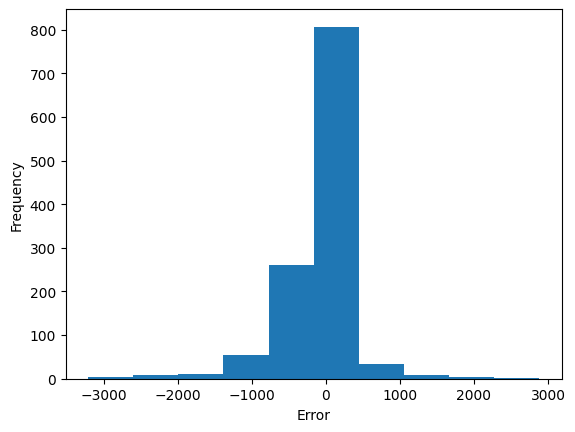

In [48]:
errors = y_test - y_pred
errors.plot(kind="hist", xlabel="Error")

<Axes: xlabel='Error', ylabel='Frequency'>

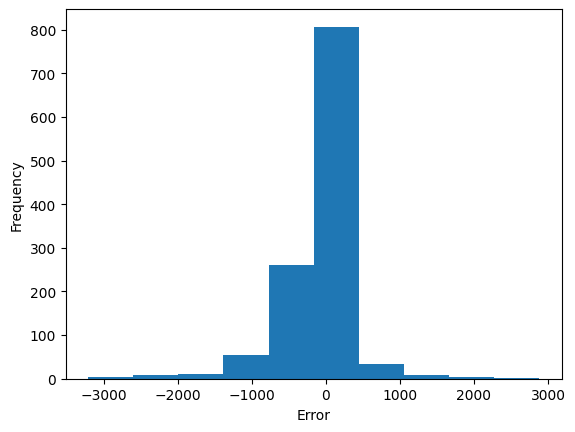

In [49]:
errors_tuned = y_test - y_pred_tuned
errors.plot(kind="hist", xlabel="Error")

# MAE and Spread for Our Untuned Model

In [50]:
std_error = np.std(errors)
mean_absolute_error = np.mean(np.abs(errors))

print(f"Standard Deviation of Errors: {std_error:.4f}")
print(f"Mean Absolute Error: {mean_absolute_error:.4f}")

Standard Deviation of Errors: 455.2760
Mean Absolute Error: 241.1722


# MAE and Spread for Our Tuned Model

In [51]:
std_error_tuned = np.std(errors_tuned)
mean_absolute_error_tuned = np.mean(np.abs(errors_tuned))

print(f"Standard Deviation of Errors: {std_error_tuned:.4f}")
print(f"Mean Absolute Error: {mean_absolute_error_tuned:.4f}")

Standard Deviation of Errors: 452.8363
Mean Absolute Error: 236.6645


# Some Additional Metrics

1. **Difference in Percent Difference**  
   - Variation between **tuned** and **untuned models** - negligible.

2. **R² > 0.99 for Both Models**  
   - Predictive accuracy or Potential overfitting.

3. **sMAPE for Pointwise Error Differences**  
   - **individual prediction errors** calculated using a symmetric approach due to scale and highly variant data.

In [52]:
print(f"Tuned vs. Untuned Difference: {np.abs(round(percent_diff_tuned-percent_diff,2))}")

Tuned vs. Untuned Difference: 0.09


In [53]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test,y_pred)
r2_tuned = r2_score(y_test,y_pred_tuned)


print(f"R2 untuned: {r2:.4f}")
print(f"R2 tuned: {r2_tuned:.4f}")

R2 untuned: 0.9927
R2 tuned: 0.9928


In [54]:
import numpy as np

def smape(y_test, y_pred):
    return np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))) * 100


print(f"sMAPE: {smape(y_test, y_pred):.2f}%")
print(f"sMAPE tuned: {smape(y_test, y_pred_tuned):.2f}%")

sMAPE: 28.33%
sMAPE tuned: 25.16%


# Marginal Difference Observed Between Tuned and Untuned Models  
The performance variation is minimal, suggesting that parameter tuning has had a limited impact on overall model effectiveness - perhaps opting for a different model might fare better - in this case, however, we opt for our untuned model to avoid potential overfitting. 

# Train, Test and Predictions Plotted for Comparison
Our tuned model might show slight overfitting, so I’d prefer to go with the untuned model for better generalization.

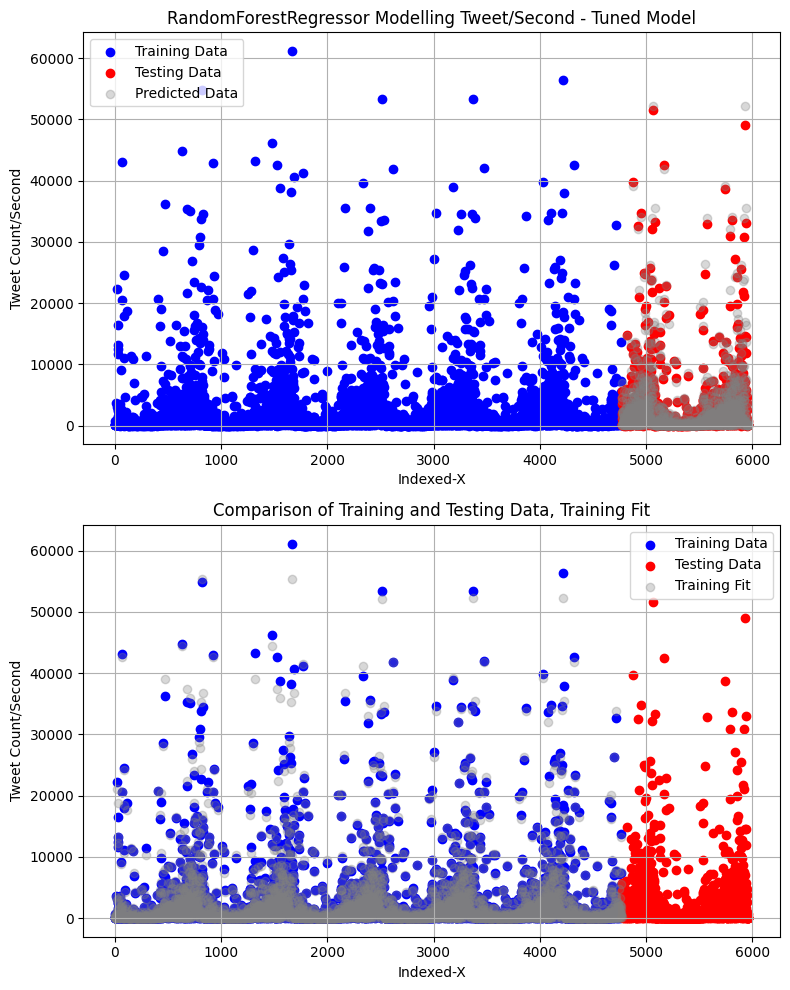

In [55]:
import matplotlib.pyplot as plt

index = twitter_aggregate.index
train_index = index[:len(y_train)]
test_index = index[len(y_train):]

fig, ax = plt.subplots(2, 1, figsize=(8, 10))


ax[0].scatter(train_index, y_train, label="Training Data", color='blue')
ax[0].scatter(test_index, y_test, label="Testing Data", color='red')
ax[0].scatter(test_index, y_pred_tuned, label="Predicted Data", color='grey', alpha=0.3)
ax[0].set_xlabel("Indexed-X")
ax[0].set_ylabel("Tweet Count/Second")
ax[0].set_title("RandomForestRegressor Modelling Tweet/Second - Tuned Model")
ax[0].legend()
ax[0].grid()


ax[1].scatter(train_index, y_train, label="Training Data", color='blue') 
ax[1].scatter(test_index, y_test, label="Testing Data", color='red')
ax[1].scatter(train_index, best_model.predict(X_train), label="Training Fit", color='grey', alpha=0.3)
ax[1].set_xlabel("Indexed-X")
ax[1].set_ylabel("Tweet Count/Second")
ax[1].set_title("Comparison of Training and Testing Data, Training Fit")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

# Final Check: Visualizing Location & Tweet Count Distribution

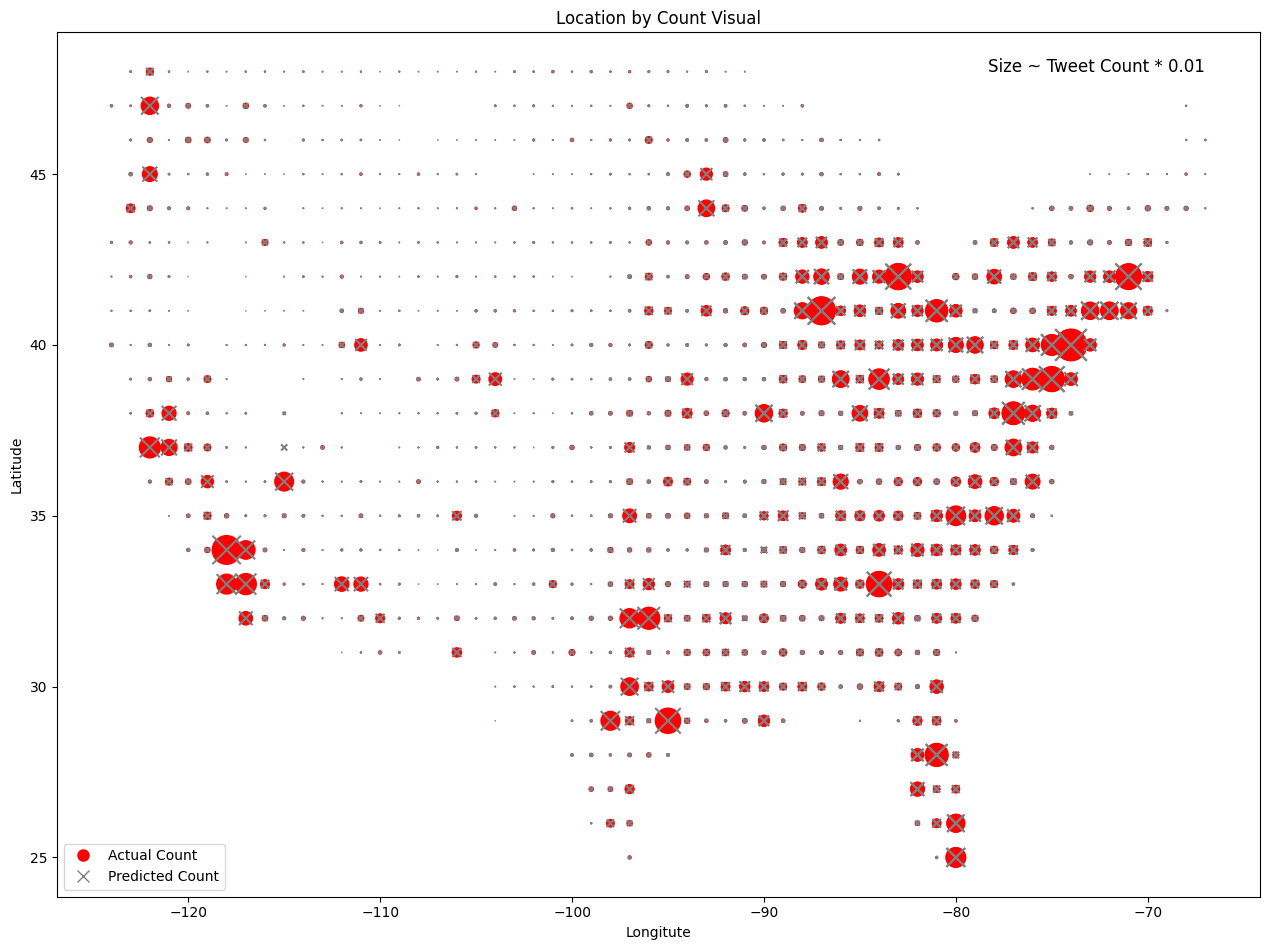

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12.8, 9.6))

ax.scatter(X_test["long"],X_test["lat"],s = twitter_aggregate["Tweet Count"][len(y_train):]*0.01, color="Red")

ax.scatter(X_test["long"],X_test["lat"],s = y_pred*0.01, marker = "x" ,color="Gray")

ax.set_xlabel("Longitute")
ax.set_ylabel("Latitude")
ax.set_title("Location by Count Visual")

legend_handles = [plt.Line2D([], [], marker="o", color="Red", linestyle="None", markersize=8, label="Actual Count"),
                  plt.Line2D([], [], marker="x", color="Gray", linestyle="None", markersize=8, label="Predicted Count")]

ax.legend(handles=legend_handles)

ax.text(X_test["long"].max(), X_test["lat"].max(), "Size ~ Tweet Count * 0.01", fontsize=12, color="black", ha="right")

plt.tight_layout()
plt.show()